In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Patch
from matplotlib.transforms import Bbox
from matplotlib.lines import Line2D
from matplotlib.ticker import FormatStrFormatter
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib

from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
from scipy.special import expit
from scipy.special import logsumexp
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint
from scipy.signal import convolve
from scipy.interpolate import interp1d

import skfda
from skfda import FDataGrid
from skfda.exploratory.visualization import plot_fpca_perturbation_graphs
from skfda.preprocessing.dim_reduction.projection import FPCA
from skfda.representation.basis import BSpline, Fourier, Monomial

import divebomb

import time
import pickle

import importlib

matplotlib.rcParams.update({'font.size': 12})
#matplotlib.rcParams.update({'lines.markersize': 20})

np.random.seed(0)
np.set_printoptions(suppress=True,precision=4)

In [2]:
from skopt import gp_minimize

In [3]:
import Preprocessor
import Parameters
import HHMM
import Visualisor

# Define Parameters

In [78]:
train_new = False

#model = 'CarHMM'
#model = 'HHMM'
#model = 'CarHHMM1'
model = 'CarHHMM2'

whale = '20190902-182840-CATs_OB_1'
#whale = '20200822-170001-Gikumi_CC_130'

year = whale[:4]

s_dive = 0
e_dive = 267 #832

share_fine_states = True

HHMM_file = '../../Params/%s/%s_%s_%s_%s' % (year,whale,s_dive,e_dive,model)

In [5]:
pars = Parameters.Parameters()

pars.cvc_file = '../Data/%s/%s.cvc' % (year,whale)
pars.csv_file = '../Data/%s/%s_001.csv' % (year,whale)

# only include for 2020 whale
#pars.stime = '2020-08-22 08:15:00'
#pars.etime = '2020-08-22 15:45:00'
#pars.drop_times = []

pars.share_fine_states = share_fine_states

pars.features = [{'dive_duration':{'corr':False,'f':'gamma'}},
                 {'Ax':{'corr':True,'f':'normal'},
                  'Ay':{'corr':True,'f':'normal'},
                  'Az':{'corr':True,'f':'normal'},
                  'Ahat_low':{'thresh':5,'corr':False,'f':'gamma'}}]

pars.K = [2,3]
if model == 'CarHMM':
    pars.K = [1,3]
elif model == 'HHMM':
    pars.features[1]['Ax']['corr'] = False
    pars.features[1]['Ay']['corr'] = False
    pars.features[1]['Az']['corr'] = False
elif model == 'CarHHMM1':
    pars.features[1] = {'Ax':{'corr':True,'f':'normal'},
                        'Ay':{'corr':True,'f':'normal'},
                        'Az':{'corr':True,'f':'normal'}}

prep = Preprocessor.Preprocessor(pars)

# Preprocess Data

In [6]:
df = prep.load_data(pars.cvc_file,
                    pars.csv_file,
                    pars.cvc_cols)

In [7]:
df = prep.prune_cols(df)

df = prep.prune_times(df,
                      pars.stime,
                      pars.etime,
                      pars.drop_times)

df = prep.fix_pressure(df)

df = prep.find_Vz(df)

df = prep.smooth_columns(df,
                         pars.smoother,
                         pars.smooth_cols)

df,dive_df = prep.find_dives(df)

data = prep.get_all_features(df,dive_df)

viz = Visualisor.Visualisor(pars,data,df)

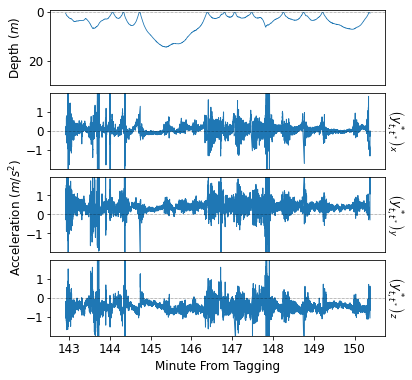

In [8]:
sdive = 140
edive = 150

fig,ax = plt.subplots(4,1,figsize = (6,6))

ax[1].yaxis.set_label_position("right")
ax[2].yaxis.set_label_position("right")
ax[3].yaxis.set_label_position("right")

temp_df = df[(df['dive_num'] >= sdive) & (df['dive_num'] <= edive)]

plt.subplot(4,1,1)
plt.plot(temp_df['hr_from_start'],temp_df['depth'],linewidth=0.8)
plt.ylim([30,-1])
plt.xticks([])
plt.axhline(0,color='k',linestyle=':',linewidth=0.5)
plt.ylabel('Depth $(m)$',fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(4,1,2)
ax = plt.gca()
ax.yaxis.set_label_coords(1.06,0.5)
ax.yaxis.set_label_position("right")
ax.set_ylabel(r'$\left(y^*_{t,t^*}\right)_x$',fontsize=12,rotation=270)
plt.plot(temp_df['hr_from_start']*60,temp_df['Ax'],linewidth=1)
plt.xticks([])
plt.ylim([-2,2])
plt.axhline(0,color='k',linestyle=':',linewidth=0.5)
plt.yticks([-1,0,1],fontsize=12)

plt.subplot(4,1,3)
ax = plt.gca()
ax.yaxis.set_label_coords(1.06,0.5)
ax.yaxis.set_label_position("right")
ax.set_ylabel(r'$\left(y^*_{t,t^*}\right)_y$',fontsize=12,rotation=270)
plt.plot(temp_df['hr_from_start']*60,temp_df['Ay'],linewidth=1)
plt.xticks([])
plt.ylim([-2,2])
plt.axhline(0,color='k',linestyle=':',linewidth=0.5)
plt.yticks([-1,0,1],fontsize=12)

plt.subplot(4,1,4)
ax = plt.gca()
ax.yaxis.set_label_coords(1.06,0.5)
ax.yaxis.set_label_position("right")
ax.set_ylabel(r'$\left(y^*_{t,t^*}\right)_z$',fontsize=12,rotation=270)
plt.plot(temp_df['hr_from_start']*60,temp_df['Az'],linewidth=1)
plt.xlabel('Minute From Tagging',fontsize=12)
plt.ylim([-2,2])
plt.axhline(0,color='k',linestyle=':',linewidth=0.5)
plt.yticks([-1,0,1],fontsize=12)
plt.xticks(fontsize=12)

fig.text(0.025, 0.4, 'Acceleration $(m/s^2)$', va='center', rotation='vertical',fontsize=12)
plt.subplots_adjust(wspace=0, hspace=0.1)



plt.savefig('../Plots/%s/%s_%s_%s_%s_raw_data_5_dives' % (year,whale,s_dive,e_dive,model),dpi=500)
plt.show()

del temp_df

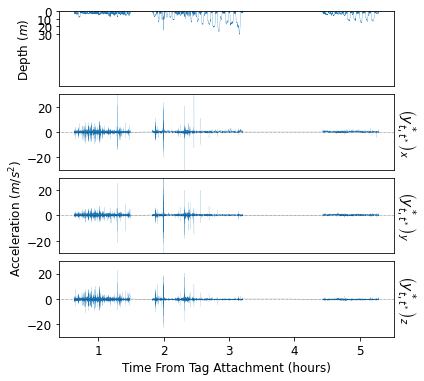

In [9]:
fig,ax = plt.subplots(4,1,figsize = (6,6),sharex=True)
ax[1].yaxis.set_label_position("right")
ax[2].yaxis.set_label_position("right")
ax[3].yaxis.set_label_position("right")

temp_df = df

plt.subplot(4,1,1)
plt.plot(temp_df['hr_from_start'],temp_df['depth'],linewidth=0.25)
#plt.show()
#plt.title('Dive Profile / Accelerometer Data',fontsize=12)
plt.ylim([100,-1])
plt.xticks([])
plt.axhline(0,color='k',linestyle=':',linewidth=0.5)
plt.ylabel('Depth $(m)$',fontsize=12)
plt.yticks([0,10,20,30],fontsize=12)
#plt.show()

plt.subplot(4,1,2)
ax = plt.gca()
ax.yaxis.set_label_coords(1.07,0.5)
ax.yaxis.set_label_position("right")
ax.set_ylabel(r'$\left(y^*_{t,t^*}\right)_x$',fontsize=14,rotation=270)
plt.plot(temp_df['hr_from_start'],temp_df['Ax'],linewidth=0.1)
plt.xticks([])
plt.ylim([-30,30])
plt.axhline(0,color='k',linestyle=':',linewidth=0.5)
plt.yticks([-20,0,20],fontsize=12)

plt.subplot(4,1,3)
ax = plt.gca()
ax.yaxis.set_label_coords(1.07,0.5)
ax.yaxis.set_label_position("right")
ax.set_ylabel(r'$\left(y^*_{t,t^*}\right)_y$',fontsize=14,rotation=270)
plt.plot(temp_df['hr_from_start'],temp_df['Ay'],linewidth=0.1)
plt.xticks([])
plt.ylim([-30,30])
plt.axhline(0,color='k',linestyle=':',linewidth=0.5)
plt.yticks([-20,0,20],fontsize=12)

plt.subplot(4,1,4)
ax = plt.gca()
ax.yaxis.set_label_coords(1.07,0.5)
ax.yaxis.set_label_position("right")
ax.set_ylabel(r'$\left(y^*_{t,t^*}\right)_z$',fontsize=14,rotation=270)
plt.plot(temp_df['hr_from_start'],temp_df['Az'],linewidth=0.1)
plt.xlabel('Time From Tag Attachment (hours)',fontsize=12)
plt.ylim([-30,30])
plt.axhline(0,color='k',linestyle=':',linewidth=0.5)
plt.yticks([-20,0,20],fontsize=12)
#plt.xticks([0,100,200,300],fontsize=12)

fig.text(0.005, 0.4, 'Acceleration $(m/s^2)$', va='center', rotation='vertical',fontsize=12)

del temp_df
plt.subplots_adjust(wspace=0, hspace=0.1)
plt.savefig('../Plots/%s/%s_%s_%s_%s_raw_data' % (year,whale,s_dive,e_dive,model),dpi=500)
plt.show()

dive_duration
[[ 1.     -0.1272]
 [-0.1272  1.    ]]
Ax
[[1.     0.8574]
 [0.8574 1.    ]]
Ay
[[1.     0.6005]
 [0.6005 1.    ]]
Az
[[1.     0.7048]
 [0.7048 1.    ]]
Ahat_low
[[1.     0.8271]
 [0.8271 1.    ]]


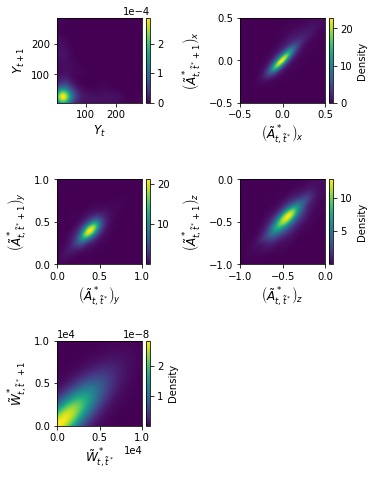

In [10]:
importlib.reload(Visualisor)
viz = Visualisor.Visualisor(pars,data,df)
viz.lagplot(lims={'peak_jerk':[0,50],
                  'roll_at_pj':[0,1],
                  'heading_var':[0,0.2],
                  'Ahat_low':[0,10000],
                  'FoVeDBA_high':[0,10],
                  'Vz':[-5,5],
                  'Ax':[-0.5,0.5],
                  'Ay':[0,1.0],
                  'Az':[-1.0,0.0]},
           file = '../Plots/%s/%s_%s_%s_%s_lagplot.png' % (year,whale,s_dive,e_dive,model))

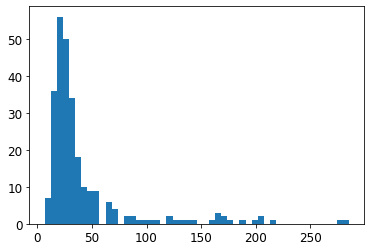

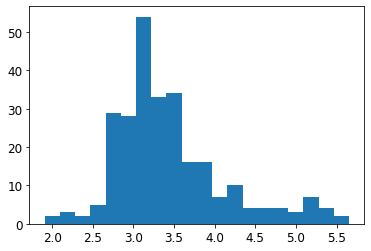

/Users/evsi8432/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning:

Pass n_components=2 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error



[[6.212 ]
 [3.5617]]
[[[1.9945]]

 [[0.7559]]]
[0.5036 0.4964]


/Users/evsi8432/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



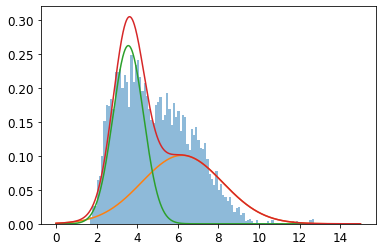

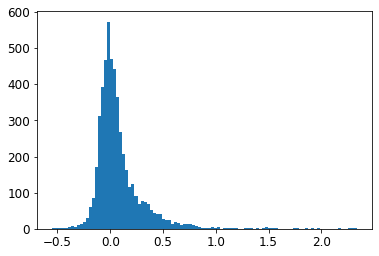

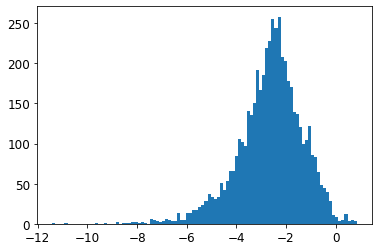

In [11]:
# plot dive duration
plt.hist([datum['dive_duration'] for datum in data],bins=50)
plt.show()

plt.hist([np.log(datum['dive_duration']) for datum in data],bins=20)
plt.show()

# get ahat and acceleration
ahat = []
acc = []
for datum in data:
    for seg in datum['subdive_features']:
        acc.append(seg['Ax'])
        ahat.append(np.log(seg['Ahat_low']))
    
# plot ahat
plt.hist(ahat,bins=100,alpha = 0.5,density=True)
n=2
from sklearn.mixture import BayesianGaussianMixture
from sklearn.mixture import GaussianMixture
GM = BayesianGaussianMixture(n,max_iter=10,n_init=10)
GM.fit(np.array(ahat).reshape(-1, 1))
print(GM.means_)
print(GM.covariances_)
print(GM.weights_)
x = np.linspace(0,15,1000)
total = np.zeros_like(x)
for i in range(n):
    plt.plot(x,norm.pdf(x,loc=GM.means_[i][0],scale=GM.covariances_[i,0,0])*GM.weights_[i]/np.sum(GM.weights_))
    total += norm.pdf(x,loc=GM.means_[i][0],scale=GM.covariances_[i,0,0])*GM.weights_[i]
plt.plot(x,total/np.sum(GM.weights_))
plt.show()
    
# plot acceleration
plt.hist(acc,bins=100)
plt.show()

# plot acceleration
plt.hist([np.log(np.abs(x)) for x in acc],bins=100)
plt.show()

# Explore FPCs

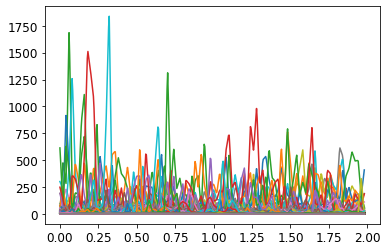

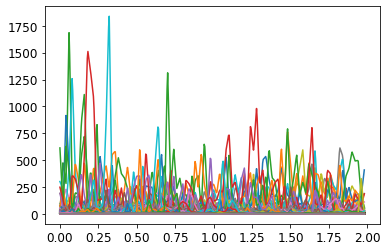

In [12]:
grid_points = np.linspace(0,1.98,100)
data_matrix = []
for dive in data:
    for seg in dive['subdive_features']:
        data_matrix.append(seg['Az_all']**2 + seg['Ay_all']**2 + seg['Ax_all']**2)
        
Ax_funcs = FDataGrid(data_matrix, grid_points)
Ax_funcs.plot()

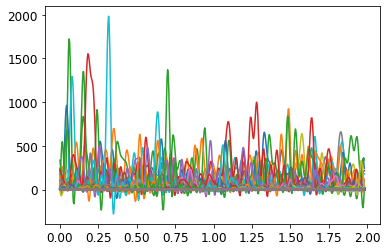

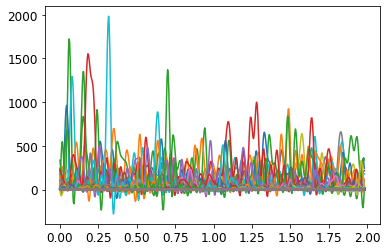

In [13]:
Ax_funcs_fourier = Ax_funcs.to_basis(skfda.representation.basis.Fourier(n_basis=99))
Ax_funcs_fourier.plot()

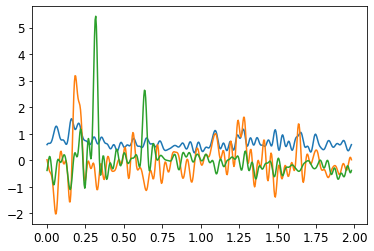

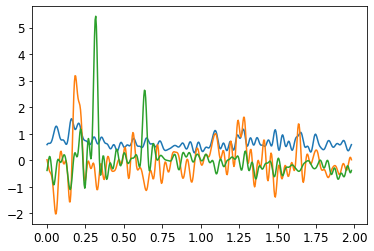

In [14]:
fpca = FPCA(n_components = 3)
fourier_coefs = fpca.fit_transform(Ax_funcs_fourier)
fpca.components_.plot()

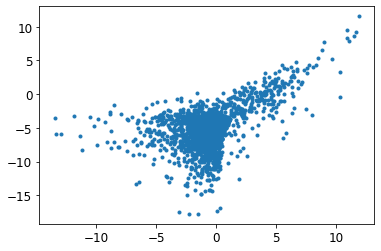

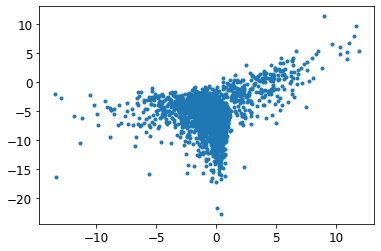

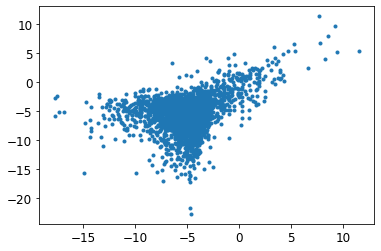

In [15]:
plt.plot(np.log(fourier_coefs[:,0]**2),np.log(fourier_coefs[:,1]**2),'.')
plt.show()
plt.plot(np.log(fourier_coefs[:,0]**2),np.log(fourier_coefs[:,2]**2),'.')
plt.show()
plt.plot(np.log(fourier_coefs[:,1]**2),np.log(fourier_coefs[:,2]**2),'.')

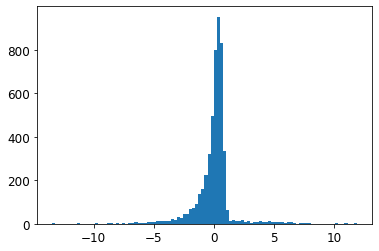

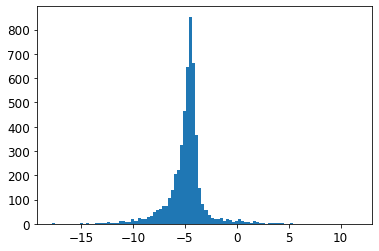

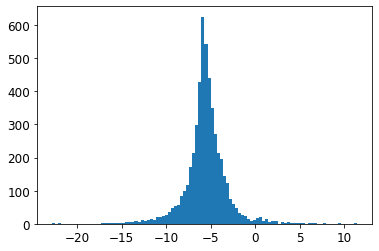

In [16]:
for i in range(3):
    plt.hist(np.log(fourier_coefs[:,i]**2),bins=100)
    plt.show()

# Train HHMM

In [42]:
deep_data = [data[i] for i in range(s_dive,e_dive)]
importlib.reload(HHMM)
hhmm = HHMM.HHMM(pars,deep_data)
hhmm = hhmm.load(HHMM_file)

best_hhmm = hhmm
l = hhmm.likelihood(deep_data)
print('original likelihood:')
print(l)
print('')
max_likelihood = l

for i in range(301,401):
    
    HHMM_file_i = '../../Params/%s/%s/CarHHMM2_k_2_3_%s' % (year,whale,i)
    
    # load model
    try:
        hhmm = hhmm.load(HHMM_file_i)
    except:
        print('No existing HMM model')
        continue
    
    l = hhmm.likelihood(deep_data)
    print(l)
    if l > max_likelihood:
        max_likelihood = l
        best_hhmm = hhmm
        print('new best model')

hhmm = best_hhmm

original likelihood:
-20348.247447404072

-21973.982737401475
-20537.397374074564
-20290.294561161227
new best model
-21723.58382239384
-23125.06622948298
-20496.39316382051
-20961.48252725887
-20307.28625790616
-20580.519778335074
-20446.885742964376
-20448.675909945232
-20412.184040066953
-23259.737456948198
-20460.47044271717
-20482.215889504354
-20336.77717977648
-20740.748012871387
-20328.782244009526
-20534.56597503235


/Users/evsi8432/Documents/Research/CarHHMM-DFT/Repository/Code/HHMM.py:280: RuntimeWarning:

divide by zero encountered in log



-20439.920552149248
-20272.86337354145
new best model
-20401.168738921268
-21651.407971501623
-22986.618011411643
-21368.472410005466
-20344.48974617886
-22190.64486354378
-20282.442781435668
-20559.255416155236
-20560.557682779745
-21803.85507698687
-20396.051731249438
-20760.879845264204
-20327.717273639082
-22907.953208633557
-20465.62800877522
-20813.862188354207
-20384.626812924376
-22135.62030555831
-23574.307716548745
-20390.547503036603
-21593.57767531078
-20585.1696190048
-20341.59931063864
-22938.880522179777
-22439.067265934445
-22835.487976634882
nan
-20382.694322139723
-20378.958174138417
-20611.710771168335
-20449.11831213182
-22815.967105044747
-20441.04087330831
-20472.042623939586
-20499.01303412618
-22872.993362206365
-22863.642857895422
-20999.783138755818
-20587.431660413404
-22868.719796817917
-23163.88334568251
-20379.75704147571
-20498.354057682176
-20451.758992643932
-22940.479510800393
-21310.885997304766
-20554.8211427991
-22766.365537555175
-20480.039557725
-

In [71]:
stime = time.time()

train_new = True

if train_new:
    print('Training new model')
    hhmm.train_DM(deep_data,max_steps=10,max_iters=5)
    
    h = 0.01
    hhmm.get_SEs(deep_data,h)

    hhmm.save(HHMM_file)

Training new model
ITERATION 0
-20272.742217203675

updated coarse eta, row 0
original:  [ 0.     -1.4858]
new:  [-1.4865]
-20272.742211299672
updated coarse eta, row 1
original:  [2.022 0.   ]
new:  [2.026]
-20272.74219026477
updated coarse theta dive_duration, state 0, param mu
original:  26.190450883371057
new:  [26.436]
-20272.66556725608
updated coarse theta dive_duration, state 0, param sig
original:  9.90915531387207
new:  [10.1569]
-20272.562886705025
updated coarse theta dive_duration, state 1, param mu
original:  112.62378189261375
new:  [116.1433]
-20272.502671814826
DANGER
updated coarse theta dive_duration, state 1, param sig
original:  65.0709550680227
new:  [65.071]
-20272.502671814826
updated fine eta, dive 0, row 0
original:  [  0.      -1.0929 -22.6511]
new:  [ -1.1013 -22.6511]
-20272.498376848696
updated fine eta, dive 0, row 1
original:  [-2.2653  0.     -2.8833]
new:  [-2.2679 -2.8758]
-20272.496031825864
updated fine eta, dive 0, row 2
original:  [-17.1832  -1.16

updated fine theta Ay, dive_state 0 subdive state 1, param mu
original:  0.4391818845355683
new:  [0.4378]
-20262.874544194496
updated fine theta Ay, dive_state 0 subdive state 1, param sig
original:  0.09645723057497763
new:  [0.0962]
-20262.84076153023
DANGER
updated fine theta Az, dive_state 0 subdive state 1, param mu
original:  -0.5731543092832667
new:  -0.5731543092832667
-20262.84076153023
updated fine theta Az, dive_state 0 subdive state 1, param sig
original:  0.11379863648204377
new:  [0.1134]
-20262.821795634354
updated fine theta Ahat_low, dive_state 0 subdive state 2, param mu
original:  10567.758040557928
new:  [10435.6611]
-20262.701009949527
updated fine theta Ahat_low, dive_state 0 subdive state 2, param sig
original:  15643.513432527758
new:  [15447.9695]
-20262.59496676814
updated fine theta Ax, dive_state 0 subdive state 2, param mu
original:  0.2294345453816674
new:  [0.2302]
-20262.594595534134
updated fine theta Ax, dive_state 0 subdive state 2, param sig
origina

-20258.333217973293
updated fine theta Ahat_low, dive_state 0 subdive state 0, param sig
original:  25.79814794674894
new:  [25.3144]
-20257.70772176012
updated fine theta Ax, dive_state 0 subdive state 0, param mu
original:  0.3987983156515229
new:  [0.4013]
-20257.703065993206
updated fine theta Ax, dive_state 0 subdive state 0, param sig
original:  0.04020972551305595
new:  [0.0401]
-20257.69207216779
updated fine theta Ax, dive_state 0 subdive state 0, param corr
original:  3.2579482174085648
new:  [3.2783]
-20257.657964809245
updated fine theta Ay, dive_state 0 subdive state 0, param mu
original:  0.44095940339688616
new:  [0.4423]
-20257.65786054825
updated fine theta Ay, dive_state 0 subdive state 0, param sig
original:  0.05195867515636998
new:  [0.0518]
-20257.646753894907
updated fine theta Az, dive_state 0 subdive state 0, param mu
original:  -0.6696540594595924
new:  [-0.6717]
-20257.64543834676
updated fine theta Az, dive_state 0 subdive state 0, param sig
original:  0.059

-20255.52167580026
updated fine theta Az, dive_state 0 subdive state 2, param mu
original:  -0.29067016367643517
new:  [-0.2916]
-20255.521433514787
updated fine theta Az, dive_state 0 subdive state 2, param sig
original:  0.36018322429761634
new:  [0.3591]
-20255.517873977344



ITERATION 5
-20255.517873977344

updated coarse eta, row 0
original:  [ 0.     -1.6456]
new:  [-1.6619]
-20255.514530814886
updated coarse eta, row 1
original:  [2.2716 0.    ]
new:  [2.2959]
-20255.513893567146
updated coarse theta dive_duration, state 0, param mu
original:  27.018676078920123
new:  [27.1031]
-20255.504759559226
updated coarse theta dive_duration, state 0, param sig
original:  10.673821670350055
new:  [10.7405]
-20255.49600836164
updated coarse theta dive_duration, state 1, param mu
original:  124.32406039300383
new:  [125.1011]
-20255.49375968888
DANGER
updated coarse theta dive_duration, state 1, param sig
original:  64.26137294391977
new:  [64.2614]
-20255.49375968888
updated fine eta, div

-20253.79026562511
DANGER
updated fine theta Ax, dive_state 0 subdive state 1, param sig
original:  0.09749370357304915
new:  0.09749370357304915
-20253.79026562511
DANGER
updated fine theta Ax, dive_state 0 subdive state 1, param corr
original:  1.561595842289155
new:  1.561595842289155
-20253.79026562511
DANGER
updated fine theta Ay, dive_state 0 subdive state 1, param mu
original:  0.43780944114639464
new:  0.43780944114639464
-20253.79026562511
DANGER
updated fine theta Ay, dive_state 0 subdive state 1, param sig
original:  0.09495947660822188
new:  0.09495947660822188
-20253.79026562511
DANGER
updated fine theta Az, dive_state 0 subdive state 1, param mu
original:  -0.5731543092832667
new:  -0.5731543092832667
-20253.79026562511
DANGER
updated fine theta Az, dive_state 0 subdive state 1, param sig
original:  0.11238280753429218
new:  0.11238280753429218
-20253.79026562511
updated fine theta Ahat_low, dive_state 0 subdive state 2, param mu
original:  10018.089825581574
new:  [9955.

-20253.141761695544
updated fine eta, dive 1, row 0
original:  [  0.      -2.0744 -13.2574]
new:  [ -2.0713 -13.2576]
-20253.14117408274
updated fine eta, dive 1, row 1
original:  [-1.6918  0.     -3.1225]
new:  [-1.6907 -3.1275]
-20253.140837502127
updated fine eta, dive 1, row 2
original:  [-16.9396  -1.2288   0.    ]
new:  [-16.9396  -1.2293]
-20253.14083469494
updated fine theta Ahat_low, dive_state 0 subdive state 0, param mu
original:  35.31155362483422
new:  [35.0909]
-20252.952643782657
updated fine theta Ahat_low, dive_state 0 subdive state 0, param sig
original:  24.14818233048816
new:  [23.9973]
-20252.860499574537
updated fine theta Ax, dive_state 0 subdive state 0, param mu
original:  0.41654020091513233
new:  [0.4191]
-20252.855096497966
DANGER
updated fine theta Ax, dive_state 0 subdive state 0, param sig
original:  0.03970945507816797
new:  0.03970945507816797
-20252.855096497966
updated fine theta Ax, dive_state 0 subdive state 0, param corr
original:  3.31948176268611

-20252.272929548133
DANGER
updated fine theta Ax, dive_state 0 subdive state 2, param sig
original:  0.29827768384124853
new:  0.29827768384124853
-20252.272929548133
DANGER
updated fine theta Ax, dive_state 0 subdive state 2, param corr
original:  0.42670535956814176
new:  0.42670535956814176
-20252.272929548133
DANGER
updated fine theta Ay, dive_state 0 subdive state 2, param mu
original:  0.3639910387649584
new:  0.3639910387649584
-20252.272929548133
updated fine theta Ay, dive_state 0 subdive state 2, param sig
original:  0.36951423855281895
new:  [0.3684]
-20252.27225609489
updated fine theta Az, dive_state 0 subdive state 2, param mu
original:  -0.2952374943155208
new:  [-0.2962]
-20252.272109855036
updated fine theta Az, dive_state 0 subdive state 2, param sig
original:  0.35793559656005597
new:  [0.3568]
-20252.270250667472




dive_duration

mu
0
1

sig
0
1

corr
0


/Users/evsi8432/Documents/Research/CarHHMM-DFT/Repository/Code/HHMM.py:947: RuntimeWarning:

divide by zero encountered in double_scalars



1

Ahat_low

mu
0
-20252.258195015183
-20252.270250667472
-20252.283018129066
1
-20252.269656583423
-20252.270250667472
-20252.270847742173
2
-20252.270241407743
-20252.270250667472
-20252.27025992897

sig
0
-20252.272224710592
-20252.270250667472
-20252.26894178096
1
-20252.27037242494
-20252.270250667472
-20252.270130933142
2
-20252.270250258724
-20252.270250667472
-20252.270251076923

corr
0
-20252.270250667472
-20252.270250667472
-20252.270250667472
1


/Users/evsi8432/Documents/Research/CarHHMM-DFT/Repository/Code/HHMM.py:1014: RuntimeWarning:

divide by zero encountered in double_scalars



-20252.270250667472
-20252.270250667472
-20252.270250667472
2
-20252.270250667472
-20252.270250667472
-20252.270250667472

Ax

mu
0
-20252.375741108743
-20252.270250667472
-20252.292061452295
1
-20252.614620089156
-20252.270250667472
-20252.593611838136
2
-20252.308128857545
-20252.270250667472
-20252.311830871808

sig
0
-20355.897722231348
-20252.270250667472
-20311.40018229882
1
-20272.4452333888
-20252.270250667472
-20268.045289029702
2
-20252.778300824786
-20252.270250667472
-20252.76424715572

corr
0
-20252.736653317552
-20252.270250667472
-20251.827141013902
1
-20254.136028662797
-20252.270250667472
-20250.435835288994
2
-20252.586196367865
-20252.270250667472
-20251.962718214458

Ay

mu
0
-20252.314591341106
-20252.270250667472
-20252.304997200034
1
-20252.60061918549
-20252.270250667472
-20252.649192523484
2
-20252.297042863305
-20252.270250667472
-20252.297518456977

sig
0
-20323.608177637227
-20252.270250667472
-20296.517951649264
1
-20275.77317254343
-20252.270250667472
-202

/Users/evsi8432/Documents/Research/CarHHMM-DFT/Repository/Code/HHMM.py:1103: RuntimeWarning:

divide by zero encountered in double_scalars



-20252.270250667472
-20252.281004391127
-20252.27219356826

1 2
0.000515121141182135
-20252.270250667472
-20252.27226483592
-20252.276029137953

2 0
2.645189517708245e-10
-20252.270250667472
-20252.270250768008
-20252.27025056695

2 1
0.002325935088458764
-20252.270250667472
-20252.27858877256
-20252.27296844886

0 1
0.0011213265509426467
-20252.270250667472
-20252.27392098049
-20252.281832525332

0 2
1.5466014890358268e-08
-20252.270250667472
-20252.27025570854
-20252.270245626474

1 0
0.0015020690721488064
-20252.270250667472
-20252.277809311618
-20252.275459123757

1 2
0.00035556047918047556
-20252.270250667472
-20252.270975325715
-20252.271860000223

2 0
3.403311165591859e-10
-20252.270250667472
-20252.27025070076
-20252.270250634207

2 1
0.002261257459698047
-20252.270250667472
-20252.272291554586
-20252.271778096892



In [79]:
hhmm.save(HHMM_file)

In [72]:
data,df = hhmm.label_df(data,df)

# Visualize Results

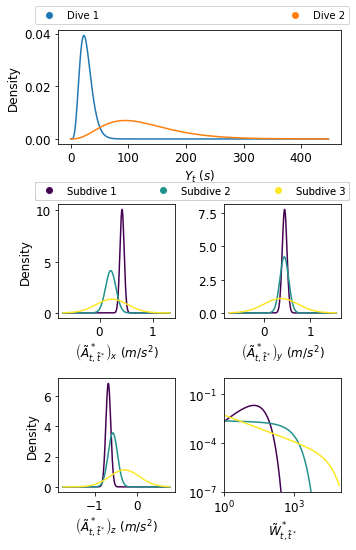

In [73]:
fig = plt.figure(figsize = (5,7.5))

gs = GridSpec(3,2)

ax1=fig.add_subplot(gs[0,:])
ax2=fig.add_subplot(gs[1,0])
ax3=fig.add_subplot(gs[1,1])
ax4=fig.add_subplot(gs[2,0])
ax5=fig.add_subplot(gs[2,1])

axs = [ax2,ax3,ax4,ax5]

# Coarse Scale
            
mu = hhmm.theta[0]['dive_duration']['mu']
sig = hhmm.theta[0]['dive_duration']['sig']

dist = pars.features[0]['dive_duration']['f']
K = pars.K[0]
colors = [cm.get_cmap('tab10')(i) for i in [0,1]]
legend = ['Dive Type %d'%(x+1) for x in range(K)]

for state in range(K):
    if dist == 'gamma':
        shape = np.square(mu)/np.square(sig)
        scale = np.square(sig)/np.array(mu)
        x = np.linspace(0.01,max(mu)+5*max(sig),100000)
        y = gamma.pdf(x,shape[state],0,scale[state])
    elif dist == 'normal':
        x = np.linspace(min(mu)-3*max(sig),max(mu)+3*max(sig),100000)
        y = norm.pdf(x,mu[state],sig[state])
    elif dist == 'vonmises':
        x = np.linspace(-np.pi,np.pi,100000)
        y = vonmises.pdf(x,sig[state],loc=mu[state])
    else:
        raise('distribution %s not recognized' % dist)
    ax1.plot(x,y,color=colors[state])
    ax1.set_ylabel('Density',fontsize=12)
    ax1.set_xlabel('$Y_t$ $(s)$')
    
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Dive 1',
                       markerfacecolor=colors[0], markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='Dive 2',
                       markerfacecolor=colors[1], markersize=8)]

fig.legend(handles=legend_elements,
           prop={'size': 10}, ncol=2,
           mode='expand',
           bbox_to_anchor=(0.1, 0.975, 0.9, 0.5),
           loc='lower left')

fine_features=['Ax','Ay','Az','Ahat_low']

# fine scale
for feature_num,feature in enumerate(fine_features):

    mu = hhmm.theta[1][0][feature]['mu']
    sig = hhmm.theta[1][0][feature]['sig']

    dist = pars.features[1][feature]['f']
    K = pars.K[1]
    colors = [cm.get_cmap('viridis')(i) for i in [0.,0.5,1.]]
    legend = ['Subdive State %d'%(x+1) for x in range(K)]

    for state in range(K):
        if dist == 'gamma':
            shape = np.square(mu)/np.square(sig)
            scale = np.square(sig)/np.array(mu)
            x = np.linspace(0.01,max(mu)+5*max(sig),100000)
            y = gamma.pdf(x,shape[state],0,scale[state])
        elif dist == 'normal':
            x = np.linspace(min(mu)-3*max(sig),max(mu)+3*max(sig),100000)
            y = norm.pdf(x,mu[state],sig[state])
        elif dist == 'vonmises':
            x = np.linspace(-np.pi,np.pi,100000)
            y = vonmises.pdf(x,sig[state],loc=mu[state])
        else:
            raise('distribution %s not recognized' % dist)
        axs[feature_num].plot(x,y,color=colors[state])
        if feature_num%2 == 0:
            axs[feature_num].set_ylabel('Density',fontsize=12)
        titles = [r'$\left(\tilde A^*_{t,\tilde t^*}\right)_x$ $(m/s^2)$',
                  r'$\left(\tilde A^*_{t,\tilde t^*}\right)_y$ $(m/s^2)$',
                  r'$\left(\tilde A^*_{t,\tilde t^*}\right)_z$ $(m/s^2)$',
                  r'$\tilde W^*_{t,\tilde t^*}$']
        title = titles[feature_num]
        axs[feature_num].set_xlabel(title,fontsize=12)
        if feature == 'Ahat_low':
            axs[feature_num].set_xscale('log')
            axs[feature_num].set_yscale('log')
            axs[feature_num].set_ylim([10e-8,10e-1])
            axs[feature_num].set_xlim([10e-1,10e4])

        legend_elements = [Line2D([0], [0], marker='o', color='w', label='Subdive 1',
                               markerfacecolor=colors[0], markersize=8),
                           Line2D([0], [0], marker='o', color='w', label='Subdive 2',
                               markerfacecolor=colors[1], markersize=8),
                           Line2D([0], [0], marker='o', color='w', label='Subdive 3',
                               markerfacecolor=colors[2], markersize=8)]

        fig.legend(handles=legend_elements,
                   prop={'size': 10}, ncol=3,
                   mode='expand',
                   bbox_to_anchor=(0.1, 0.65, 0.9, 0.5),
                   loc='lower left')

plt.tight_layout()
bbox = Bbox([[0,0],[5,8]])
file = '../Plots/%s/%s_%s_%s_%s_all_emissions.png' % (year,whale,s_dive,e_dive,model)
plt.savefig(file,bbox_inches=bbox,dpi=500)
plt.show()

-20252.270250667472
Probability transistion matrix for dive types:
[[0.8453 0.1547]
 [0.9127 0.0873]]

Stationary distribution for dive types:
[[0.8551 0.1449]]




Probability transistion matrix for subdive behaviors, dive type 1:
[[0.7479 0.2521 0.    ]
 [0.0817 0.8668 0.0515]
 [0.     0.2326 0.7674]]

Stationary Distribution for subdive behaviors, dive type 1:
[[0.2097 0.647  0.1433]]


Probability transistion matrix for subdive behaviors, dive type 2:
[[0.8879 0.1121 0.    ]
 [0.1502 0.8142 0.0356]
 [0.     0.2261 0.7739]]

Stationary Distribution for subdive behaviors, dive type 2:
[[0.5365 0.4005 0.063 ]]




/Users/evsi8432/Documents/Research/CarHHMM-DFT/Repository/Code/Visualisor.py:507: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



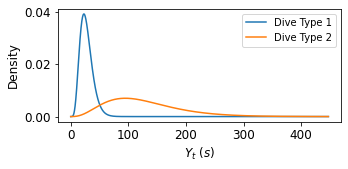

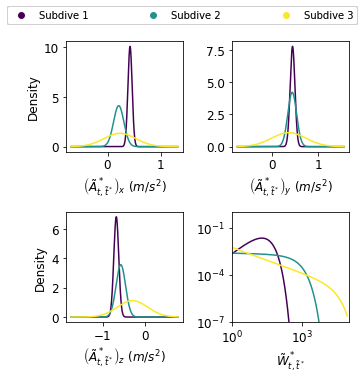

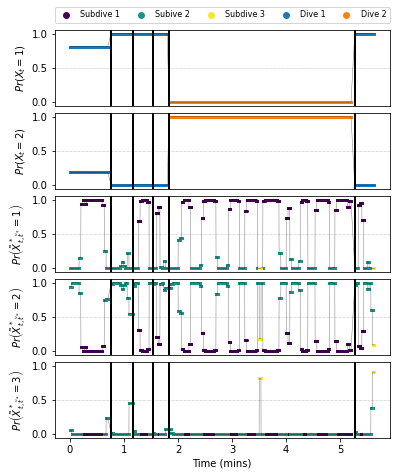

/Users/evsi8432/Documents/Research/CarHHMM-DFT/Repository/Code/Visualisor.py:507: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



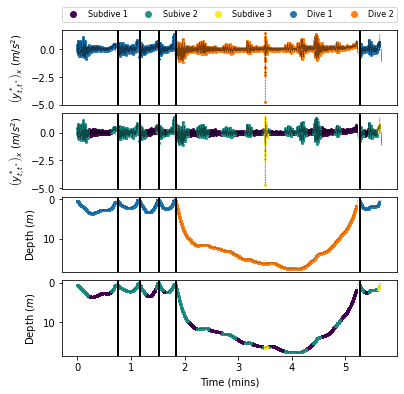

In [74]:
print(hhmm.likelihood(deep_data))

sdive = 160
edive = 165

importlib.reload(Visualisor)
viz = Visualisor.Visualisor(pars,data,df)
viz.hhmm = hhmm
#rcParams.update({'figure.autolayout': True})
viz.plot_emission_probs(0,file='../Plots/%s/%s_%s_%s_%s-coarse-emissions.png'%(year,whale,s_dive,e_dive,model))
if model == 'CarHHMM1':
    viz.plot_emission_probs(1,
                            file='../Plots/%s/%s_%s_%s_%s-fine-emissions.png' % (year,whale,s_dive,e_dive,model),
                            features=['Ax','Ay','Az'])
else:
    viz.plot_emission_probs(1,file='../Plots/%s/%s_%s_%s_%s-fine-emissions.png' % (year,whale,s_dive,e_dive,model))
viz.print_ptms()
if model != 'CarHMM':
    viz.plot_dive_features(sdive,edive,['dive_state_0_prob',
                                    'dive_state_1_prob',
                                    'subdive_state_0_prob',
                                    'subdive_state_1_prob',
                                    'subdive_state_2_prob'],[],
                           file = '../Plots/%s/%s_%s_%s_%s_decoded_states.png' % (year,whale,s_dive,e_dive,model),
                           nrows = 5)
else:
    viz.plot_dive_features(sdive,edive,['dive_state_0_prob',
                                    'subdive_state_0_prob',
                                    'subdive_state_1_prob',
                                    'subdive_state_2_prob'],[],
                           ylabs = [r'$Pr\left(X_t = 1\right)$',
                                    r'$Pr\left(\tilde X^*_{t,\tilde t^*} = 1\right)$',
                                    r'$Pr\left(\tilde X^*_{t,\tilde t^*} = 2\right)$',
                                    r'$Pr\left(\tilde X^*_{t,\tilde t^*} = 3\right)$'],
                           file = '../Plots/%s/%s_%s_%s_%s_decoded_states.png' % (year,whale,s_dive,e_dive,model),
                           nrows = 4)
    
plt.show()

viz.plot_dive_features(sdive,edive,['Ax','depth'],[],
                       file = '../Plots/%s/%s_%s_%s_%s_decoded_dives.png' % (year,whale,s_dive,e_dive,model),
                       ylabs = [r'$\left(y^*_{t,t^*}\right)_x$ $(m/s^2)$',r'Depth $(m)$'],
                       nrows = 4)

# Histograms over emission distributions

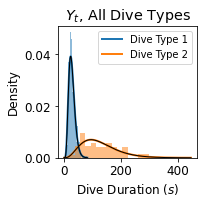

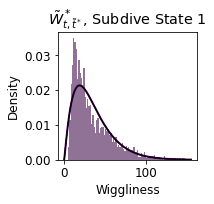

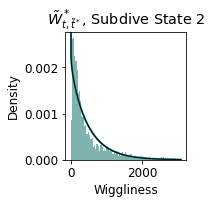

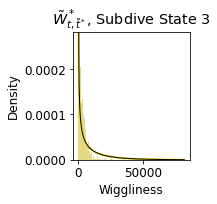

Ax


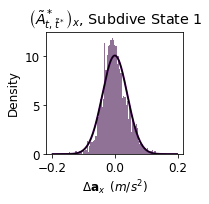

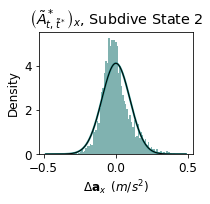

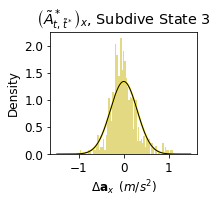

Ay


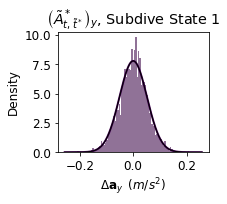

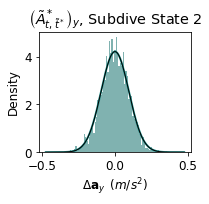

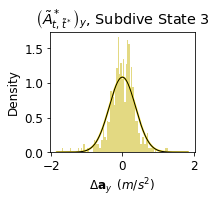

Az


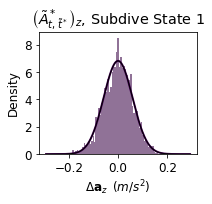

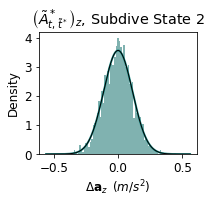

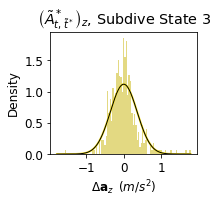

In [75]:
# colors
dive_colors = [cm.get_cmap('tab10')(0),
               cm.get_cmap('tab10')(1)]
subdive_colors = [cm.get_cmap('viridis')(0),
                  cm.get_cmap('viridis')(0.5),
                  cm.get_cmap('viridis')(1.0)]

# dive duration
weights = [list([]),list([])]
values = []

for dive in data:
    weights[0].append(dive['dive_state_probs'][0])
    if model != 'CarHMM':
        weights[1].append(dive['dive_state_probs'][1])
    values.append(dive['dive_duration'])
        
mu = hhmm.theta[0]['dive_duration']['mu']
sig = hhmm.theta[0]['dive_duration']['sig']
shape = np.square(mu)/np.square(sig)
scale = np.square(sig)/np.array(mu)

plt.figure(figsize=(3,3))
for state in range(hhmm.pars.K[0]):
    bins = np.linspace(0.01,mu[state]+5*sig[state],25)
    x = np.linspace(0.01,mu[state]+5*sig[state],10000)
    y = gamma.pdf(x,shape[state],0,scale[state])
    plt.hist(values,weights=weights[state],density=True,bins=bins,color=dive_colors[state],alpha=0.5)
    plt.plot(x,y,color=dive_colors[state],linewidth=2)

if model != 'CarHMM':
    plt.legend(['Dive Type 1','Dive Type 2'],fontsize=10)
for state in range(hhmm.pars.K[0]):
    x = np.linspace(0.01,mu[state]+5*sig[state],10000)
    y = gamma.pdf(x,shape[state],0,scale[state])
    plt.plot(x,y,color='k',linewidth=1)
plt.title('$Y_t$, All Dive Types')
plt.ylabel('Density')
plt.xlabel('Dive Duration $(s)$')
plt.tight_layout()
plt.savefig('../Plots/%s/%s_%s_%s_%s_empirical_hist_dive_duration.png' % (year,whale,s_dive,e_dive,model),
            dpi=500)
plt.show()
    
# A-hat
if model != 'CarHHMM1':
    weights = [list([]),list([]),list([])]
    values = []

    for dive in data:
        for seg in dive['subdive_features']:
            weights[0].append(seg['subdive_state_probs'][0])
            weights[1].append(seg['subdive_state_probs'][1])
            weights[2].append(seg['subdive_state_probs'][2])
            values.append(seg['Ahat_low'])

    mu = hhmm.theta[1][0]['Ahat_low']['mu']
    sig = hhmm.theta[1][0]['Ahat_low']['sig']
    shape = np.square(mu)/np.square(sig)
    scale = np.square(sig)/np.array(mu)
    for state in range(hhmm.pars.K[1]):
        plt.figure(figsize=(3,3))
        bins = np.linspace(0.01,mu[state]+5*sig[state],100)
        plt.hist(values,weights=weights[state],density=True,bins=bins,color=subdive_colors[state],alpha=0.5)
        xlim = plt.gca().get_xlim()
        ylim = plt.gca().get_ylim()
        x = np.linspace(0.01,mu[state]+5*sig[state],10000)
        y = gamma.pdf(x,shape[state],0,scale[state])
        plt.plot(x,y,color='k',linewidth=1)
        plt.title(r'$\tilde W^*_{t,\tilde t^*}$, Subdive State %d'%(state+1))
        plt.xlim(xlim)
        plt.xlabel('Wiggliness')
        plt.ylim(ylim)
        plt.ylabel('Density')
        #plt.legend(['Fit Distribution','Empirical Histogram'],fontsize=12)
        plt.hist(values,weights=weights[state],density=True,bins=bins,color='k',alpha=0.1)
        plt.plot(x,y,color=subdive_colors[state],linewidth=2)
        plt.plot(x,y,color='k',linewidth=1)
        plt.tight_layout()
        plt.savefig('../Plots/%s/%s_%s_%s_%s_empirical_hist_ahat_%d.png' % (year,whale,s_dive,e_dive,model,state),
            dpi=500)
        plt.show()
    
    
# Ax
for feature in ['Ax','Ay','Az']:
    print(feature)
    weights = [list([]),list([]),list([])]
    values = [list([]),list([]),list([])]

    mu = hhmm.theta[1][0][feature]['mu']
    sig = hhmm.theta[1][0][feature]['sig']
    corr = expit(hhmm.theta[1][0][feature]['corr'])

    for state in range(hhmm.pars.K[1]):
        for dive in data:
            seg_tm1 = dive['subdive_features'][0]
            for seg in dive['subdive_features'][1:]:
                weights[state].append(seg['subdive_state_probs'][state])
                values[state].append(seg[feature] - (corr[state]*seg_tm1[feature] + (1.0-corr[state])*mu[state]))
                seg_tm1 = seg
                
    for state in range(hhmm.pars.K[1]):
        plt.figure(figsize=(3,3))
        bins = np.linspace(-5*sig[state],5*sig[state],100)
        plt.hist(values[state],weights=weights[state],density=True,bins=bins,
                 color=subdive_colors[state],alpha=0.5)
        x = np.linspace(-5*sig[state],5*sig[state],10000)
        y = norm.pdf(x,0,sig[state])
        plt.plot(x,y,color=subdive_colors[state],linewidth=2)
        plt.ylabel('Density')
        plt.xlabel('$\Delta \mathbf{a}_%s \enspace (m/s^2)$'%feature[-1])
        plt.title(r'$\left(\tilde A^*_{t,\tilde t^*}\right)_%s$, Subdive State %d'%(feature[-1],state+1))
        #plt.legend(['Fit Distribution','Empirical Histogram'],fontsize=12)
        plt.plot(x,y,color='k',linewidth=1)
        plt.hist(values[state],weights=weights[state],density=True,bins=bins,
                 color='k',alpha=0.1)
        plt.tight_layout()
        plt.savefig('../Plots/%s/%s_%s_%s_%s_empirical_hist_%s_%d' % (year,whale,s_dive,e_dive,model,feature,state),
                    dpi=500)
        plt.show()

# Psuedoresiduals

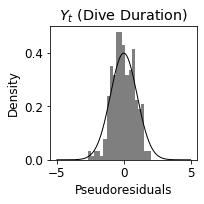

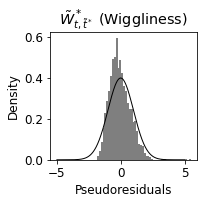

Ax


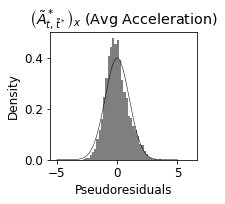

Ay


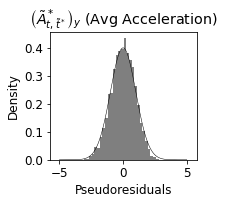

Az


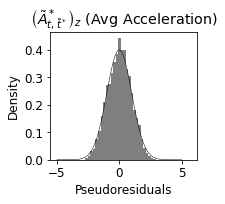

In [76]:
x = np.linspace(-5,5,1000)
y = norm.pdf(x)

# dive duration
mu = hhmm.theta[0]['dive_duration']['mu']
sig = hhmm.theta[0]['dive_duration']['sig']
shape = np.square(mu)/np.square(sig)
scale = np.square(sig)/np.array(mu)

psuedoresids = []

for dive in data:
    cdf = 0
    for state in range(hhmm.pars.K[0]):
        cdf += dive['dive_state_probs'][state] * \
               gamma.cdf(dive['dive_duration'],
                         shape[state],0,scale[state])
    if cdf >= 1.0:
        cdf = 0.9999
        
    psuedoresids.append(norm.ppf(cdf))

plt.figure(figsize=(3,3))
plt.hist(psuedoresids,density=True,bins=20,color='k',alpha=0.5)
plt.title('$Y_t$ (Dive Duration)')
plt.plot(x,y,color='k',linewidth=1)
plt.xlabel('Pseudoresiduals')
plt.ylabel('Density')
#plt.legend(['$\phi(\cdot)$','Pseudoresids'],fontsize=12)
plt.tight_layout()
plt.savefig('../Plots/%s/%s_%s_%s_%s_pseudresids_dive_duration.png' % (year,whale,s_dive,e_dive,model),dpi=500)
plt.show()

# A-hat
if model != 'CarHHMM1':
    mu = hhmm.theta[1][0]['Ahat_low']['mu']
    sig = hhmm.theta[1][0]['Ahat_low']['sig']
    shape = np.square(mu)/np.square(sig)
    scale = np.square(sig)/np.array(mu)

    psuedoresids = []

    for dive in data:
        for seg in dive['subdive_features']:
            cdf = 0
            for state in range(hhmm.pars.K[1]):
                cdf += seg['subdive_state_probs'][state] * \
                        gamma.cdf(seg['Ahat_low'],shape[state],0,scale[state])
            if cdf >= 1.0:
                cdf = 0.9999
            psuedoresids.append(norm.ppf(cdf))

    plt.figure(figsize=(3,3))     
    plt.hist(psuedoresids,density=True,bins=50,color='k',alpha=0.5)
    plt.title(r'$\tilde W^*_{t,\tilde t^*}$ (Wiggliness)')
    plt.plot(x,y,color='k',linewidth=1)
    plt.xlabel('Pseudoresiduals')
    plt.ylabel('Density')
    #plt.legend(['$\phi(\cdot)$','Pseudoresids'],fontsize=12)
    plt.tight_layout()
    plt.savefig('../Plots/%s/%s_%s_%s_%s_pseudresids_ahat.png' % (year,whale,s_dive,e_dive,model),dpi=500)
    plt.show() 

for feature in ['Ax','Ay','Az']:
    print(feature)
    mu = hhmm.theta[1][0][feature]['mu']
    sig = hhmm.theta[1][0][feature]['sig']
    corr = expit(hhmm.theta[1][0][feature]['corr'])
    
    psuedoresids = []

    for state in range(hhmm.pars.K[1]):
        for dive in data:
            seg_tm1 = dive['subdive_features'][0]
            for seg in dive['subdive_features'][1:]:
                cdf = 0
                for state in range(hhmm.pars.K[1]):
                    mean = corr[state]*seg_tm1[feature] + (1.0-corr[state])*mu[state]
                    cdf += seg['subdive_state_probs'][state] * \
                            norm.cdf(seg[feature],mean,sig[state])
                seg_tm1 = seg
                if cdf >= 1.0:
                    cdf = 0.9999
                psuedoresids.append(norm.ppf(cdf))
                
    plt.figure(figsize=(3,3))
    plt.hist(psuedoresids,density=True,bins=50,color='k',alpha=0.5)
    plt.plot(x,y,color='k',linewidth=0.5)
    plt.title(r'$\left(\tilde A^*_{t,\tilde t^*}\right)_%s$ (Avg Acceleration)'%feature[-1])
    plt.xlabel('Pseudoresiduals')
    plt.ylabel('Density')
    #plt.legend(['$\phi(\cdot)$','Pseudoresids'],fontsize=10)
    plt.tight_layout()
    plt.savefig('../Plots/%s/%s_%s_%s_%s_pseudresids_%s.png' % (year,whale,s_dive,e_dive,model,feature),dpi=500)
    plt.show()   

# Make Tables

In [59]:
if model == 'CarHHMM2':
    table = r'''
    \begin{table}[h!]
    \centering
    \label{table:emis_dists}
    \caption{Estimates and standard errors of parameters for killer whale data.}
    \begin{tabular}{ccccc}
    \multirow{2}{*}{Feature}                                                       & \multirow{2}{*}{Dive / Subdive Type} & \multicolumn{3}{c}{Parameter Estimate}              \\
                                                                                   &                                      & $\hat \mu$      & $\hat \sigma$   & $\hat \phi$     \\ \hline
    \multirow{2}{*}{Dive Duration $(s)$ - $Y$}                                     & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\ \hline
    \multirow{3}{*}{x-acceleration $(m/s^2)$ - $\tilde A^*_x$}                            & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\ \hline
    \multirow{3}{*}{y-acceleration $(m/s^2)$ - $\tilde A^*_y$}                            & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\ \hline
    \multirow{3}{*}{z-acceleration $(m/s^2)$ - $\tilde A^*_z$}                            & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\ \hline
    \multirow{3}{*}{Fourier sum - $\tilde W^*$}                                           & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\ \hline
    \end{tabular}
    \end{table}
    ''' % (hhmm.theta[0]['dive_duration']['mu'][0],hhmm.SEs['dive_duration']['mu'][0],
           hhmm.theta[0]['dive_duration']['sig'][0],hhmm.SEs['dive_duration']['sig'][0],
           hhmm.theta[0]['dive_duration']['mu'][1],hhmm.SEs['dive_duration']['mu'][1],
           hhmm.theta[0]['dive_duration']['sig'][1],hhmm.SEs['dive_duration']['sig'][1],
           hhmm.theta[1][0]['Ax']['mu'][0],hhmm.SEs['Ax']['mu'][0],
           hhmm.theta[1][0]['Ax']['sig'][0],hhmm.SEs['Ax']['sig'][0],
           expit(hhmm.theta[1][0]['Ax']['corr'][0]),hhmm.SEs['Ax']['corr'][0],
           hhmm.theta[1][0]['Ax']['mu'][1],hhmm.SEs['Ax']['mu'][1],
           hhmm.theta[1][0]['Ax']['sig'][1],hhmm.SEs['Ax']['sig'][1],
           expit(hhmm.theta[1][0]['Ax']['corr'][1]),hhmm.SEs['Ax']['corr'][1],
           hhmm.theta[1][0]['Ax']['mu'][2],hhmm.SEs['Ax']['mu'][2],
           hhmm.theta[1][0]['Ax']['sig'][2],hhmm.SEs['Ax']['sig'][2],
           expit(hhmm.theta[1][0]['Ax']['corr'][2]),hhmm.SEs['Ax']['corr'][2],
           hhmm.theta[1][0]['Ay']['mu'][0],hhmm.SEs['Ay']['mu'][0],
           hhmm.theta[1][0]['Ay']['sig'][0],hhmm.SEs['Ay']['sig'][0],
           expit(hhmm.theta[1][0]['Ay']['corr'][0]),hhmm.SEs['Ay']['corr'][0],
           hhmm.theta[1][0]['Ay']['mu'][1],hhmm.SEs['Ay']['mu'][1],
           hhmm.theta[1][0]['Ay']['sig'][1],hhmm.SEs['Ay']['sig'][1],
           expit(hhmm.theta[1][0]['Ay']['corr'][1]),hhmm.SEs['Ay']['corr'][1],
           hhmm.theta[1][0]['Ay']['mu'][2],hhmm.SEs['Ay']['mu'][2],
           hhmm.theta[1][0]['Ay']['sig'][2],hhmm.SEs['Ay']['sig'][2],
           expit(hhmm.theta[1][0]['Ay']['corr'][2]),hhmm.SEs['Ay']['corr'][2],
           hhmm.theta[1][0]['Az']['mu'][0],hhmm.SEs['Az']['mu'][0],
           hhmm.theta[1][0]['Az']['sig'][0],hhmm.SEs['Az']['sig'][0],
           expit(hhmm.theta[1][0]['Az']['corr'][0]),hhmm.SEs['Az']['corr'][0],
           hhmm.theta[1][0]['Az']['mu'][1],hhmm.SEs['Az']['mu'][1],
           hhmm.theta[1][0]['Az']['sig'][1],hhmm.SEs['Az']['sig'][1],
           expit(hhmm.theta[1][0]['Az']['corr'][1]),hhmm.SEs['Az']['corr'][1],
           hhmm.theta[1][0]['Az']['mu'][2],hhmm.SEs['Az']['mu'][2],
           hhmm.theta[1][0]['Az']['sig'][2],hhmm.SEs['Az']['sig'][2],
           expit(hhmm.theta[1][0]['Az']['corr'][2]),hhmm.SEs['Az']['corr'][2],
           hhmm.theta[1][0]['Ahat_low']['mu'][0],hhmm.SEs['Ahat_low']['mu'][0],
           hhmm.theta[1][0]['Ahat_low']['sig'][0],hhmm.SEs['Ahat_low']['sig'][0],
           hhmm.theta[1][0]['Ahat_low']['mu'][1],hhmm.SEs['Ahat_low']['mu'][1],
           hhmm.theta[1][0]['Ahat_low']['sig'][1],hhmm.SEs['Ahat_low']['sig'][1],
           hhmm.theta[1][0]['Ahat_low']['mu'][2],hhmm.SEs['Ahat_low']['mu'][2],
           hhmm.theta[1][0]['Ahat_low']['sig'][2],hhmm.SEs['Ahat_low']['sig'][2])

    print(table)
    
elif model == 'CarHHMM1':
    
    table = r'''
    \begin{table}[h!]
    \centering
    \label{table:emis_dists}
    \caption{Estimates and standard errors of parameters for killer whale data.}
    \begin{tabular}{ccccc}
    \multirow{2}{*}{Feature}                                                       & \multirow{2}{*}{Dive / Subdive Type} & \multicolumn{3}{c}{Parameter Estimate}              \\
                                                                                   &                                      & $\hat \mu$      & $\hat \sigma$   & $\hat \phi$     \\ \hline
    \multirow{2}{*}{Dive Duration $(s)$ - $Y$}                                     & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\ \hline
    \multirow{3}{*}{x-acceleration $(m/s^2)$ - $\tilde A^*_x$}                            & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\ \hline
    \multirow{3}{*}{y-acceleration $(m/s^2)$ - $\tilde A^*_y$}                            & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\ \hline
    \multirow{3}{*}{z-acceleration $(m/s^2)$ - $\tilde A^*_z$}                            & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\ \hline
    \end{tabular}
    \end{table}
    ''' % (hhmm.theta[0]['dive_duration']['mu'][0],hhmm.SEs['dive_duration']['mu'][0],
           hhmm.theta[0]['dive_duration']['sig'][0],hhmm.SEs['dive_duration']['sig'][0],
           hhmm.theta[0]['dive_duration']['mu'][1],hhmm.SEs['dive_duration']['mu'][1],
           hhmm.theta[0]['dive_duration']['sig'][1],hhmm.SEs['dive_duration']['sig'][1],
           hhmm.theta[1][0]['Ax']['mu'][0],hhmm.SEs['Ax']['mu'][0],
           hhmm.theta[1][0]['Ax']['sig'][0],hhmm.SEs['Ax']['sig'][0],
           expit(hhmm.theta[1][0]['Ax']['corr'][0]),hhmm.SEs['Ax']['corr'][0],
           hhmm.theta[1][0]['Ax']['mu'][1],hhmm.SEs['Ax']['mu'][1],
           hhmm.theta[1][0]['Ax']['sig'][1],hhmm.SEs['Ax']['sig'][1],
           expit(hhmm.theta[1][0]['Ax']['corr'][1]),hhmm.SEs['Ax']['corr'][1],
           hhmm.theta[1][0]['Ax']['mu'][2],hhmm.SEs['Ax']['mu'][2],
           hhmm.theta[1][0]['Ax']['sig'][2],hhmm.SEs['Ax']['sig'][2],
           expit(hhmm.theta[1][0]['Ax']['corr'][2]),hhmm.SEs['Ax']['corr'][2],
           hhmm.theta[1][0]['Ay']['mu'][0],hhmm.SEs['Ay']['mu'][0],
           hhmm.theta[1][0]['Ay']['sig'][0],hhmm.SEs['Ay']['sig'][0],
           expit(hhmm.theta[1][0]['Ay']['corr'][0]),hhmm.SEs['Ay']['corr'][0],
           hhmm.theta[1][0]['Ay']['mu'][1],hhmm.SEs['Ay']['mu'][1],
           hhmm.theta[1][0]['Ay']['sig'][1],hhmm.SEs['Ay']['sig'][1],
           expit(hhmm.theta[1][0]['Ay']['corr'][1]),hhmm.SEs['Ay']['corr'][1],
           hhmm.theta[1][0]['Ay']['mu'][2],hhmm.SEs['Ay']['mu'][2],
           hhmm.theta[1][0]['Ay']['sig'][2],hhmm.SEs['Ay']['sig'][2],
           expit(hhmm.theta[1][0]['Ay']['corr'][2]),hhmm.SEs['Ay']['corr'][2],
           hhmm.theta[1][0]['Az']['mu'][0],hhmm.SEs['Az']['mu'][0],
           hhmm.theta[1][0]['Az']['sig'][0],hhmm.SEs['Az']['sig'][0],
           expit(hhmm.theta[1][0]['Az']['corr'][0]),hhmm.SEs['Az']['corr'][0],
           hhmm.theta[1][0]['Az']['mu'][1],hhmm.SEs['Az']['mu'][1],
           hhmm.theta[1][0]['Az']['sig'][1],hhmm.SEs['Az']['sig'][1],
           expit(hhmm.theta[1][0]['Az']['corr'][1]),hhmm.SEs['Az']['corr'][1],
           hhmm.theta[1][0]['Az']['mu'][2],hhmm.SEs['Az']['mu'][2],
           hhmm.theta[1][0]['Az']['sig'][2],hhmm.SEs['Az']['sig'][2],
           expit(hhmm.theta[1][0]['Az']['corr'][2]),hhmm.SEs['Az']['corr'][2])

    print(table)
    
elif model == 'HHMM':
    
    table = r'''
    \begin{table}[h!]
    \centering
    \label{table:emis_dists}
    \caption{Estimates and standard errors of parameters for killer whale data.}
    \begin{tabular}{ccccc}
    \multirow{2}{*}{Feature}                                                       & \multirow{2}{*}{Dive / Subdive Type} & \multicolumn{3}{c}{Parameter Estimate}              \\
                                                                                   &                                      & $\hat \mu$      & $\hat \sigma$   & $\hat \phi$     \\ \hline
    \multirow{2}{*}{Dive Duration $(s)$ - $Y$}                                     & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\ \hline
    \multirow{3}{*}{x-acceleration $(m/s^2)$ - $\tilde A^*_x$}                            & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\ \hline
    \multirow{3}{*}{y-acceleration $(m/s^2)$ - $\tilde A^*_y$}                            & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\ \hline
    \multirow{3}{*}{z-acceleration $(m/s^2)$ - $\tilde A^*_z$}                            & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\ \hline
    \multirow{3}{*}{Wiggliness - $\tilde W^*$}                                            & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\ \hline
    \end{tabular}
    \end{table}
    ''' % (hhmm.theta[0]['dive_duration']['mu'][0],hhmm.SEs['dive_duration']['mu'][0],
           hhmm.theta[0]['dive_duration']['sig'][0],hhmm.SEs['dive_duration']['sig'][0],
           hhmm.theta[0]['dive_duration']['mu'][1],hhmm.SEs['dive_duration']['mu'][1],
           hhmm.theta[0]['dive_duration']['sig'][1],hhmm.SEs['dive_duration']['sig'][1],
           hhmm.theta[1][0]['Ax']['mu'][0],hhmm.SEs['Ax']['mu'][0],
           hhmm.theta[1][0]['Ax']['sig'][0],hhmm.SEs['Ax']['sig'][0],
           hhmm.theta[1][0]['Ax']['mu'][1],hhmm.SEs['Ax']['mu'][1],
           hhmm.theta[1][0]['Ax']['sig'][1],hhmm.SEs['Ax']['sig'][1],
           hhmm.theta[1][0]['Ax']['mu'][2],hhmm.SEs['Ax']['mu'][2],
           hhmm.theta[1][0]['Ax']['sig'][2],hhmm.SEs['Ax']['sig'][2],
           hhmm.theta[1][0]['Ay']['mu'][0],hhmm.SEs['Ay']['mu'][0],
           hhmm.theta[1][0]['Ay']['sig'][0],hhmm.SEs['Ay']['sig'][0],
           hhmm.theta[1][0]['Ay']['mu'][1],hhmm.SEs['Ay']['mu'][1],
           hhmm.theta[1][0]['Ay']['sig'][1],hhmm.SEs['Ay']['sig'][1],
           hhmm.theta[1][0]['Ay']['mu'][2],hhmm.SEs['Ay']['mu'][2],
           hhmm.theta[1][0]['Ay']['sig'][2],hhmm.SEs['Ay']['sig'][2],
           hhmm.theta[1][0]['Az']['mu'][0],hhmm.SEs['Az']['mu'][0],
           hhmm.theta[1][0]['Az']['sig'][0],hhmm.SEs['Az']['sig'][0],
           hhmm.theta[1][0]['Az']['mu'][1],hhmm.SEs['Az']['mu'][1],
           hhmm.theta[1][0]['Az']['sig'][1],hhmm.SEs['Az']['sig'][1],
           hhmm.theta[1][0]['Az']['mu'][2],hhmm.SEs['Az']['mu'][2],
           hhmm.theta[1][0]['Az']['sig'][2],hhmm.SEs['Az']['sig'][2],
           hhmm.theta[1][0]['Ahat_low']['mu'][0],hhmm.SEs['Ahat_low']['mu'][0],
           hhmm.theta[1][0]['Ahat_low']['sig'][0],hhmm.SEs['Ahat_low']['sig'][0],
           hhmm.theta[1][0]['Ahat_low']['mu'][1],hhmm.SEs['Ahat_low']['mu'][1],
           hhmm.theta[1][0]['Ahat_low']['sig'][1],hhmm.SEs['Ahat_low']['sig'][1],
           hhmm.theta[1][0]['Ahat_low']['mu'][2],hhmm.SEs['Ahat_low']['mu'][2],
           hhmm.theta[1][0]['Ahat_low']['sig'][2],hhmm.SEs['Ahat_low']['sig'][2])

    print(table)
    
elif model == 'CarHMM':
    
    table = r'''
    \begin{table}[h!]
    \centering
    \label{table:emis_dists}
    \caption{Estimates and standard errors of parameters for killer whale data.}
    \begin{tabular}{ccccc}
    \multirow{2}{*}{Feature}                                                       & \multirow{2}{*}{Dive / Subdive Type} & \multicolumn{3}{c}{Parameter Estimate}              \\
                                                                                   &                                      & $\hat \mu$      & $\hat \sigma$   & $\hat \phi$     \\ \hline
    \multirow{1}{*}{Dive Duration $(s)$ - $Y$}                                     & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\ \hline
    \multirow{3}{*}{x-acceleration $(m/s^2)$ - $\tilde A^*_x$}                            & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\ \hline
    \multirow{3}{*}{y-acceleration $(m/s^2)$ - $\tilde A^*_y$}                            & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\ \hline
    \multirow{3}{*}{z-acceleration $(m/s^2)$ - $\tilde A^*_z$}                            & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\ \hline
    \multirow{3}{*}{Fourier sum - $\tilde W^*$}                                           & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\ \hline
    \end{tabular}
    \end{table}
    ''' % (hhmm.theta[0]['dive_duration']['mu'][0],hhmm.SEs['dive_duration']['mu'][0],
           hhmm.theta[0]['dive_duration']['sig'][0],hhmm.SEs['dive_duration']['sig'][0],
           hhmm.theta[1][0]['Ax']['mu'][0],hhmm.SEs['Ax']['mu'][0],
           hhmm.theta[1][0]['Ax']['sig'][0],hhmm.SEs['Ax']['sig'][0],
           expit(hhmm.theta[1][0]['Ax']['corr'][0]),hhmm.SEs['Ax']['corr'][0],
           hhmm.theta[1][0]['Ax']['mu'][1],hhmm.SEs['Ax']['mu'][1],
           hhmm.theta[1][0]['Ax']['sig'][1],hhmm.SEs['Ax']['sig'][1],
           expit(hhmm.theta[1][0]['Ax']['corr'][1]),hhmm.SEs['Ax']['corr'][1],
           hhmm.theta[1][0]['Ax']['mu'][2],hhmm.SEs['Ax']['mu'][2],
           hhmm.theta[1][0]['Ax']['sig'][2],hhmm.SEs['Ax']['sig'][2],
           expit(hhmm.theta[1][0]['Ax']['corr'][2]),hhmm.SEs['Ax']['corr'][2],
           hhmm.theta[1][0]['Ay']['mu'][0],hhmm.SEs['Ay']['mu'][0],
           hhmm.theta[1][0]['Ay']['sig'][0],hhmm.SEs['Ay']['sig'][0],
           expit(hhmm.theta[1][0]['Ay']['corr'][0]),hhmm.SEs['Ay']['corr'][0],
           hhmm.theta[1][0]['Ay']['mu'][1],hhmm.SEs['Ay']['mu'][1],
           hhmm.theta[1][0]['Ay']['sig'][1],hhmm.SEs['Ay']['sig'][1],
           expit(hhmm.theta[1][0]['Ay']['corr'][1]),hhmm.SEs['Ay']['corr'][1],
           hhmm.theta[1][0]['Ay']['mu'][2],hhmm.SEs['Ay']['mu'][2],
           hhmm.theta[1][0]['Ay']['sig'][2],hhmm.SEs['Ay']['sig'][2],
           expit(hhmm.theta[1][0]['Ay']['corr'][2]),hhmm.SEs['Ay']['corr'][2],
           hhmm.theta[1][0]['Az']['mu'][0],hhmm.SEs['Az']['mu'][0],
           hhmm.theta[1][0]['Az']['sig'][0],hhmm.SEs['Az']['sig'][0],
           expit(hhmm.theta[1][0]['Az']['corr'][0]),hhmm.SEs['Az']['corr'][0],
           hhmm.theta[1][0]['Az']['mu'][1],hhmm.SEs['Az']['mu'][1],
           hhmm.theta[1][0]['Az']['sig'][1],hhmm.SEs['Az']['sig'][1],
           expit(hhmm.theta[1][0]['Az']['corr'][1]),hhmm.SEs['Az']['corr'][1],
           hhmm.theta[1][0]['Az']['mu'][2],hhmm.SEs['Az']['mu'][2],
           hhmm.theta[1][0]['Az']['sig'][2],hhmm.SEs['Az']['sig'][2],
           expit(hhmm.theta[1][0]['Az']['corr'][2]),hhmm.SEs['Az']['corr'][2],
           hhmm.theta[1][0]['Ahat_low']['mu'][0],hhmm.SEs['Ahat_low']['mu'][0],
           hhmm.theta[1][0]['Ahat_low']['sig'][0],hhmm.SEs['Ahat_low']['sig'][0],
           hhmm.theta[1][0]['Ahat_low']['mu'][1],hhmm.SEs['Ahat_low']['mu'][1],
           hhmm.theta[1][0]['Ahat_low']['sig'][1],hhmm.SEs['Ahat_low']['sig'][1],
           hhmm.theta[1][0]['Ahat_low']['mu'][2],hhmm.SEs['Ahat_low']['mu'][2],
           hhmm.theta[1][0]['Ahat_low']['sig'][2],hhmm.SEs['Ahat_low']['sig'][2])

    print(table)


    \begin{table}[h!]
    \centering
    \label{table:emis_dists}
    \caption{Estimates and standard errors of parameters for killer whale data.}
    \begin{tabular}{ccccc}
    \multirow{2}{*}{Feature}                                                       & \multirow{2}{*}{Dive / Subdive Type} & \multicolumn{3}{c}{Parameter Estimate}              \\
                                                                                   &                                      & $\hat \mu$      & $\hat \sigma$   & $\hat \phi$     \\ \hline
    \multirow{2}{*}{Dive Duration $(s)$ - $Y$}                                     & 1                                    & $26.190 \pm 0.603$ & $9.909 \pm 0.512$ & ---             \\
                                                                                   & 2                                    & $112.624 \pm 10.231$ & $65.071 \pm 8.244$ & ---             \\ \hline
    \multirow{3}{*}{x-acceleration $(m/s^2)$ - $\tilde A^*_x$}                    

In [60]:
if model != 'CarHMM':
    ptm = HHMM.eta_2_ptm(hhmm.eta[0])
    delta = np.array([0.5,0.5])
    for _ in range(100):
        delta = delta.dot(ptm)

    gamma0 = r'''$$\hat \Gamma = \begin{pmatrix} 
    %.3f & %.3f \\
    %.3f & %.3f
    \end{pmatrix}$$
    $$\hat \delta = \begin{pmatrix} %.3f & %.3f \end{pmatrix}$$
    '''% tuple(np.concatenate([ptm.flatten(),delta]))

    print(gamma0)

$$\hat \Gamma = \begin{pmatrix} 
    0.815 & 0.185 \\
    0.883 & 0.117
    \end{pmatrix}$$
    $$\hat \delta = \begin{pmatrix} 0.827 & 0.173 \end{pmatrix}$$
    


In [61]:
ptm1 = HHMM.eta_2_ptm(hhmm.eta[1][0])
delta1 = np.array([0.3333,0.3333,0.3334])
for _ in range(100):
    delta1 = delta1.dot(ptm1)
    
if model != 'CarHMM':
    
    ptm2 = HHMM.eta_2_ptm(hhmm.eta[1][1])
    delta2 = np.array([0.3333,0.3333,0.3334])
    for _ in range(100):
        delta2 = delta2.dot(ptm2)

    gamma0 = r'''$$\hat \Gamma^{*(1)} = \begin{pmatrix} 
    %.3f & %.3f & %.3f \\
    %.3f & %.3f & %.3f \\
    %.3f & %.3f & %.3f
    \end{pmatrix}$$
    $$\hat \delta^{*(1)} = \begin{pmatrix} %.3f & %.3f & %.3f \end{pmatrix}$$

    $$\hat \Gamma^{*(2)} = \begin{pmatrix} 
    %.3f & %.3f & %.3f \\
    %.3f & %.3f & %.3f \\
    %.3f & %.3f & %.3f
    \end{pmatrix}$$
    $$\hat \delta^{*(2)} = \begin{pmatrix} %.3f & %.3f & %.3f \end{pmatrix}$$
    ''' % tuple(np.concatenate([ptm1.flatten(),delta1,ptm2.flatten(),delta2]))
    
else:
    
    gamma0 = r'''$$\hat \Gamma^{*(1)} = \begin{pmatrix} 
    %.3f & %.3f & %.3f \\
    %.3f & %.3f & %.3f \\
    %.3f & %.3f & %.3f
    \end{pmatrix}$$
    $$\hat \delta^{*(1)} = \begin{pmatrix} %.3f & %.3f & %.3f \end{pmatrix}$$
    ''' % tuple(np.concatenate([ptm1.flatten(),delta1]))
    
print(gamma0)

$$\hat \Gamma^{*(1)} = \begin{pmatrix} 
    0.749 & 0.251 & 0.000 \\
    0.089 & 0.862 & 0.048 \\
    0.000 & 0.237 & 0.763
    \end{pmatrix}$$
    $$\hat \delta^{*(1)} = \begin{pmatrix} 0.228 & 0.641 & 0.131 \end{pmatrix}$$

    $$\hat \Gamma^{*(2)} = \begin{pmatrix} 
    0.892 & 0.108 & 0.000 \\
    0.144 & 0.815 & 0.041 \\
    0.000 & 0.225 & 0.775
    \end{pmatrix}$$
    $$\hat \delta^{*(2)} = \begin{pmatrix} 0.530 & 0.398 & 0.073 \end{pmatrix}$$
    


# Make plots of likelihood